# LSTM model of StockData

[Intro to LSTM](https://machinelearningmastery.com/gentle-introduction-long-short-term-memory-networks-experts/)

In this notebook we will go through a basic Long Short Term Memory (LSTM) model for time series. The notebooks does the following things:
* First load in the data. The preproccessing only consist of normalization and the creation of windows.
* Creation of the LSTM model
* Training the LSTM model
* Testing the LSTM model with 1 time step and with 1 window

## Importing libraries and loading in the data

### Import libraries

In [1]:
import matplotlib.pyplot as plt
import statsmodels.tsa.seasonal as smt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import random
import datetime as dt
from sklearn import linear_model 
from sklearn.metrics import mean_absolute_error
importarchive (1) plotly

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout


In [28]:
from subprocess import check_output
import os
os.chdir('C://Users/Steph/Downloads/archive/')
path = 'C://Users/Steph/Downloads/archive/'
#location of your data
print(os.listdir(path))
os.chdir('C://Users/Steph/Downloads/archive/Data/Stocks')

['Data', 'ETFs', 'Stocks']


### 1) Loading in the data

Select a stock or ETF for this HW from the ones available. 

In [29]:
filenames = 'bgr.us.txt'#"<insert file name>"
print(filenames)

df = pd.read_csv(filenames, sep=',')
df['Label'] = filenames
df['Date'] = pd.to_datetime(df['Date'])

bgr.us.txt


### Visualize the data

Plotly is a nice visualization library that has some interactive plot options.

In [30]:
r = lambda: random.randint(0,255)
traces = []

#for df in data:
clr = str(r()) + str(r()) + str(r())
df = df.sort_values('Date')
label = df['Label'].iloc[0]

trace = plotly.graph_objs.Scattergl(
    x=df['Date'],
    y=df['Close']#,mode='line',line=dict(color = "blue")
)
traces.append(trace)
    
layout = plotly.graph_objs.Layout(
    title='Plot '+label.split(sep='.')[0].upper(),
)
fig = plotly.graph_objs.Figure(data=traces, layout=layout)

plotly.offline.init_notebook_mode(connected=True)
plotly.offline.iplot(fig, filename='dataplot')

### 2) Creating windows and normalizing the data

The default window here is 10. The final question will ask you to consider this parameter in your final analysis and how it might impact your results.

In [119]:
window_len = 10

#Create a data point (i.e. a date) which splits the training and testing set
split_date = list(df["Date"][-(2*window_len+1):])[0]
print("split_date:",split_date)

#Split the training and test set
training_set, test_set = df[df['Date'] < split_date], df[df['Date'] >= split_date]
training_set = training_set.drop(['Date','Label', 'OpenInt'], 1)
test_set = test_set.drop(['Date','Label','OpenInt'], 1)

#Create windows for training
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['Close'][window_len:].values/training_set['Close'][:-window_len].values)-1

LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

#Create windows for testing
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    
    for col in list(temp_set):
        temp_set[col] = temp_set[col]/temp_set[col].iloc[0] - 1
    
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['Close'][window_len:].values/test_set['Close'][:-window_len].values)-1

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

split_date: 2017-10-13 00:00:00


C:\Users\Steph\AppData\Local\Temp/ipykernel_14912/184136286.py:9: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only

C:\Users\Steph\AppData\Local\Temp/ipykernel_14912/184136286.py:10: FutureWarning:

In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only



## 3) LSTM model definition

LSTM's have a set of parameters that can be tuned to your data set. Consider these inputs: **activation function, loss function, dropout rate, optimizer, nn layers/architecture** and review your options in the documentation.

[Keras Docs](https://keras.io/api/layers/recurrent_layers/lstm/)

In [137]:
def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.60, loss="mae", optimizer="adam"):
    
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

## 4) Training of the LSTM model

Just like most ML models choosing a stopping condition is important. Here we use **Epochs** or iterations to set this stopping condition where we also monitor the loss at each step. Consider **Epochs** as a parameter to adjust.

In [138]:
# initialise model architecture
nn_model = build_model(LSTM_training_inputs, output_size=1, neurons = 32)
# model output is next price normalised to 10th previous closing price
# train model on data
# note: eth_history contains information on the training error per epoch
nn_history = nn_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=20, batch_size=50, verbose=2, shuffle=True)

Epoch 1/20
64/64 - 1s - loss: 0.0494 - 1s/epoch - 22ms/step
Epoch 2/20
64/64 - 0s - loss: 0.0288 - 160ms/epoch - 3ms/step
Epoch 3/20
64/64 - 0s - loss: 0.0242 - 168ms/epoch - 3ms/step
Epoch 4/20
64/64 - 0s - loss: 0.0212 - 155ms/epoch - 2ms/step
Epoch 5/20
64/64 - 0s - loss: 0.0195 - 167ms/epoch - 3ms/step
Epoch 6/20
64/64 - 0s - loss: 0.0189 - 160ms/epoch - 2ms/step
Epoch 7/20
64/64 - 0s - loss: 0.0182 - 164ms/epoch - 3ms/step
Epoch 8/20
64/64 - 0s - loss: 0.0180 - 163ms/epoch - 3ms/step
Epoch 9/20
64/64 - 0s - loss: 0.0176 - 169ms/epoch - 3ms/step
Epoch 10/20
64/64 - 0s - loss: 0.0170 - 171ms/epoch - 3ms/step
Epoch 11/20
64/64 - 0s - loss: 0.0168 - 166ms/epoch - 3ms/step
Epoch 12/20
64/64 - 0s - loss: 0.0170 - 168ms/epoch - 3ms/step
Epoch 13/20
64/64 - 0s - loss: 0.0170 - 167ms/epoch - 3ms/step
Epoch 14/20
64/64 - 0s - loss: 0.0171 - 199ms/epoch - 3ms/step
Epoch 15/20
64/64 - 0s - loss: 0.0165 - 175ms/epoch - 3ms/step
Epoch 16/20
64/64 - 0s - loss: 0.0157 - 166ms/epoch - 3ms/step
Epo

### Plot of prediction of one data point ahead
As can be seen in the plot, one step prediction is not bad. The scale is a bit off, because the data is normalized. 

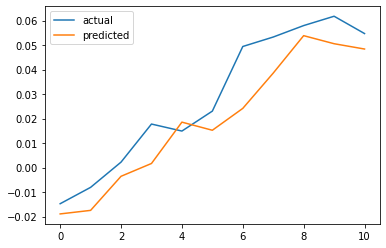

The Mean Absolute Error is: 0.009864024863584085


In [139]:
plt.plot(LSTM_test_outputs, label = "actual")
plt.plot(nn_model.predict(LSTM_test_inputs), label = "predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, nn_model.predict(LSTM_test_inputs))
print('The Mean Absolute Error is: {}'.format(MAE))

### Prediction of one window (n steps) ahead
As can be seen in the plot below, the performance degrades when predicting multiple time points ahead. However, compered to something like linear regression the performance is better. 

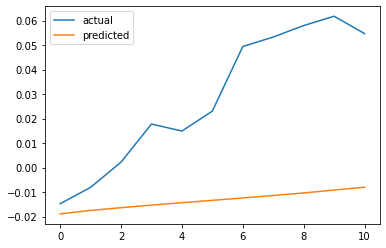

The Mean Absolute Error is: 0.04175671586952737


In [140]:
def predict_sequence_full(model, data, window_size):
    #Shift the window by 1 new prediction each time, re-run predictions on new window
    curr_frame = data[0]
    predicted = []
    for i in range(len(data)):
        predicted.append(model.predict(curr_frame[np.newaxis,:,:])[0,0])
        curr_frame = curr_frame[1:]
        curr_frame = np.insert(curr_frame, [window_size-1], predicted[-1], axis=0)
    return predicted

predictions = predict_sequence_full(nn_model, LSTM_test_inputs, 10)

plt.plot(LSTM_test_outputs, label="actual")
plt.plot(predictions, label="predicted")
plt.legend()
plt.show()
MAE = mean_absolute_error(LSTM_test_outputs, predictions)
print('The Mean Absolute Error is: {}'.format(MAE))

## Conclusion

For this HW your task is to select a stock or ETF from the provided folder. You will run the code above with the default parameters and understand the logic and flow of the program. Once you are confident the code runs you are to test different parameter settings. You are to report the best set of parameters that you find and explain the importance of each parameter and how it impacts the training of the model. To best know how much to adjust and how to interpret the impacts I suggest changing one parameter at a time. This is a manual grid search you are performing so that you can become familiar with each parameter. In the future you can have grid search algorithms find the best set for you. 

For each define the parameter and it's impact to the model. Report the set of values tested and the best parameter setting you found for each.

1) Window Length - 10 The size of looking back timesteps of LSTM.
The choice of Window length of LSTM should depend on the dataset. we also need to think about the accuracy and computation complexity of the model when selecting the window size.
2) LSTM Parameter: activation function- Linear. To model a nonlinear problem, we can directly introduce a nonlinearity by activation function.
The choice of activation function in the hidden layer will control how well the network model learns the training dataset.  
The choice of activation function in the output layer will define the type of predictions the model can make. 
3) LSTM Parameter: loss function - MAE mean absolute error. Loss function is the formula that we set to judge the accuracy of our deep learning model.
The choice of loss function should depend on our modeling choice. Genearlly, it's a standard that we use for how far are a model’s 
predictions from its labels.
4) LSTM Parameter: dropout rate - 0.1
The default interpretation of the dropout hyperparameter is the probability of training a given node in a layer, where 1.0 means no dropout, and 0.0 means no outputs from the layer. A good value for dropout in a hidden layer is between 0.5 and 0.8.
5) LSTM Parameter: optimizer - adam
Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models. Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.
6) LSTM Parameter: nn layers/architecture - 74
The architecture of nerual networks. For LSTM it is the number of nn in the hidden layer that we use.
7) Epochs - 50
The training epoch times that we set for our model. It's a balance between consumptiont time, overfitting and accuracy.